# Drug Nomenclature

    T0: First timepoint 
    (Time Zero, after selection of cells with sgRNA library, and starting point of drug dosing)
    DMSO: DMSO treated 
    Pi: PARP inhibitor (olaparib; AZD2281)
    Ri: ATR inhibitor (AZD6738)
    Wi: WEE1 inhibitor (AZD1775)
    Mi: ATM inhibitor (AZD0156)
    Ki: DNAPK inhibitor (AZD7648)


    PiRi: PARP inhibitor + ATR inhibitor
    PiWi: PARP inhibitor + WEE1 inhibitor
    PiMi: PARP inhibitor + ATM inhibitor
    PiKi: PARP inhibitor + DNAPK inhibitor

# Load data

In [1]:
import sys
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from venn import venn 
from upsetplot import from_contents,UpSet
from matplotlib.backends.backend_pdf import PdfPages
import stringdb

sys.path.append("/rumi/shams/abe/Projects/ScreenProcessing/")

import screen_analysis as scpro
from utils import *

In [2]:
# help(scpro)

In [3]:
Ci = scpro.loadData('CRISPRi/Analysis/PiKiMiRiWi/PiKiMiRiWi_2reps')

Ca = scpro.loadData('CRISPRa/Analysis/k562/k562a_PiRi')

## CRISPRi Analysis
    gamma:T0:DMSO
    rho1:DMSO:Pi
    rho2:DMSO:Ki
    rho3:DMSO:Mi
    rho4:DMSO:Ri
    rho5:DMSO:Wi
    rho6:DMSO:PiKi
    rho7:DMSO:PiMi
    rho8:DMSO:PiRi
    rho9:DMSO:PiWi



In [4]:
Ci_data = {
    'Pi':{'rho':  get_score(Ci,'rho1','Pi')},
    'Ki':{'rho':  get_score(Ci,'rho2','Ki')},
    'Mi':{'rho':  get_score(Ci,'rho3','Mi')},
    'Ri':{'rho':  get_score(Ci,'rho4','Ri')},
    'Wi':{'rho':  get_score(Ci,'rho5','Wi')},
    'PiKi':{'rho':  get_score(Ci,'rho6','PiKi')},
    'PiMi':{'rho':  get_score(Ci,'rho7','PiMi')},
    'PiRi':{'rho':  get_score(Ci,'rho8','PiRi')},
    'PiWi':{'rho':  get_score(Ci,'rho9','PiWi')}
}

### z-score

In [5]:
Ci_df = pd.concat([Ci_data[drug]['rho'] for drug in Ci_data.keys()],axis=1).filter(regex='rho$', axis=1)

Ci_df_norm = stats.zscore(Ci_df,axis=1,ddof=1)

Ca_df = pd.concat([Ci_data[drug]['rho'] for drug in Ci_data.keys()],axis=1).filter(regex='rho$', axis=1)

Ca_df_norm = stats.zscore(Ci_df,axis=1,ddof=1)

Get PPI genes 

In [6]:
genes = ['PRDX1']
string_ids = stringdb.get_string_ids(genes)
enrichment_df = stringdb.get_enrichment(string_ids.queryItem)

In [7]:
ppi = stringdb.get_interaction_partners(
    string_ids.queryItem
).sort_values('score',ascending=False).preferredName_B.to_list()

ppi = set(Ci_df.dropna().index.to_list()).intersection(set(ppi))

go = set([gene for i in range(30) for gene in enrichment_df.loc[i,'inputGenes'].split(',')])

# Plots

In [8]:
!mkdir -p figures

#### Heatmap

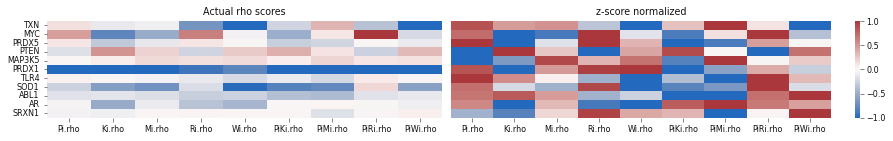

In [9]:
# plot 
genes = go


f,(ax1,ax2) = plt.subplots(1,2, gridspec_kw={'width_ratios':[0.1,0.12]}, figsize=(13,2))

ax1.get_shared_y_axes().join(ax1,ax2)

g1 = sns.heatmap(
    Ci_df.loc[genes,:], 
#     annot=True,
    vmin=-1, vmax=1,
    cmap="vlag",
    cbar=False,
    ax=ax1
)

g1.set_ylabel('')
g1.set_xlabel('')
g1.set_title('Actual rho scores')

g2 = sns.heatmap(
    Ci_df_norm.loc[genes,:], 
#     annot=True,
    vmin=-1, vmax=1,
    cmap="vlag",
    ax=ax2
)

g2.set_ylabel('')
g2.set_xlabel('')
g2.set_title('z-score normalized')
g2.set_yticks([])

# may be needed to rotate the ticklabels correctly:
for ax in [g1,g2]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=0)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)


f.tight_layout()
plt.savefig('figures/rho_zscore_heatmap.pdf')

#### Corr plot

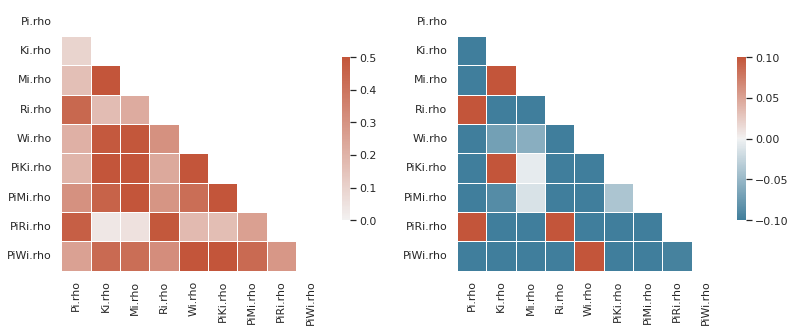

In [15]:
sns.set_theme(style="white")

fig_c,(ax1,ax2) = plt.subplots(1,2, gridspec_kw={'width_ratios':[0.1,0.1]}, figsize=(13,6))

plot_corr(Ci_df,ax1,vmin=0,vmax=0.5)
'Actual rho scores'
plot_corr(Ci_df_norm,ax2,vmin=-0.1,vmax=0.1)
'z-score normalized'

plt.savefig('figures/rho_zscore_corr.pdf')
plt.show()

#### Heatmap Clustering 

In [35]:
# %%time 
# # The PDF document
# pdf_pages = PdfPages('figures/rho_zscore_heatmap_clustering.pdf')
    
# fig_u1 = plt.figure(figsize=(5, 5), dpi=300)
# fig_u2 = plt.figure(figsize=(5, 5), dpi=300)

# g1 = sns.clustermap(
#     Ci_df.dropna(),
# #     vmin=-1, vmax=1,
#     cmap="vlag")

# g1.fig.suptitle('Actual rho scores')
# g1.fig.axes[2].set_ylabel('')
# pdf_pages.savefig(g1.fig)

# g2 = sns.clustermap(
#     Ci_df_norm.dropna(),
#     vmin=-1, vmax=1,
#     cmap="vlag")

# g2.fig.suptitle('z-score normalized')
# g2.fig.axes[2].set_ylabel('')
# pdf_pages.savefig(g2.fig)

# # Write the PDF document to the disk
# pdf_pages.close()

#### Histogram 

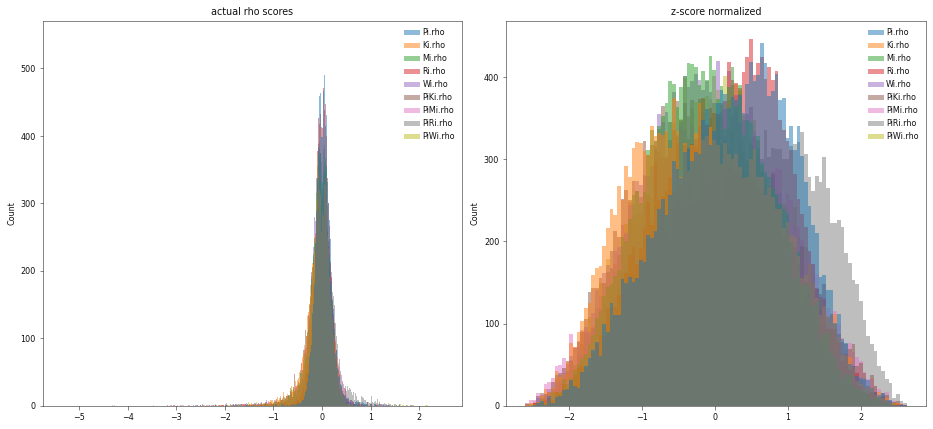

In [11]:
# plot 
fig_h,(ax1,ax2) = plt.subplots(1,2, gridspec_kw={'width_ratios':[0.1,0.1]}, figsize=(13,6))

al = 0.5

# ax1.get_shared_y_axes().join(ax1,ax2)

h1 = sns.histplot(Ci_df,alpha = al,ax=ax1)
h1.set_title('actual rho scores')

h2 = sns.histplot(Ci_df_norm,alpha = al,ax=ax2)
h2.set_title('z-score normalized')

fig_h.tight_layout()
plt.savefig('figures/rho_zscore_histogram.pdf')
plt.show()

# Intersectional analysis 

In [1]:
df = pd.concat(
    [
        Ci_df_norm, 
        pd.concat([Ci_data[drug]['rho'] for drug in Ci_data.keys()],axis=1).filter(regex='pvalue$', axis=1)
    ],axis=1).sort_index(axis=1)

for drug in Ci_data.keys():
    print (drug)
    up,dn = find_top(df.filter(regex=f'{drug}*',axis=1),f'{drug}.rho',0.5,f'{drug}.pvalue',0.01)
    Ci_data[drug]['up'] = up.index.to_list()
    Ci_data[drug]['dn'] = dn.index.to_list()
    print ('_'*8)

NameError: name 'pd' is not defined

In [13]:
UpSetData_up = from_contents(dict([(drug+' up',Ci_data[drug]['up']) for drug in Ci_data]))
UpSetData_dn = from_contents(dict([(drug+' dn',Ci_data[drug]['dn']) for drug in Ci_data]))

#### UpSet.plot

CPU times: user 563 ms, sys: 28.1 ms, total: 591 ms
Wall time: 597 ms


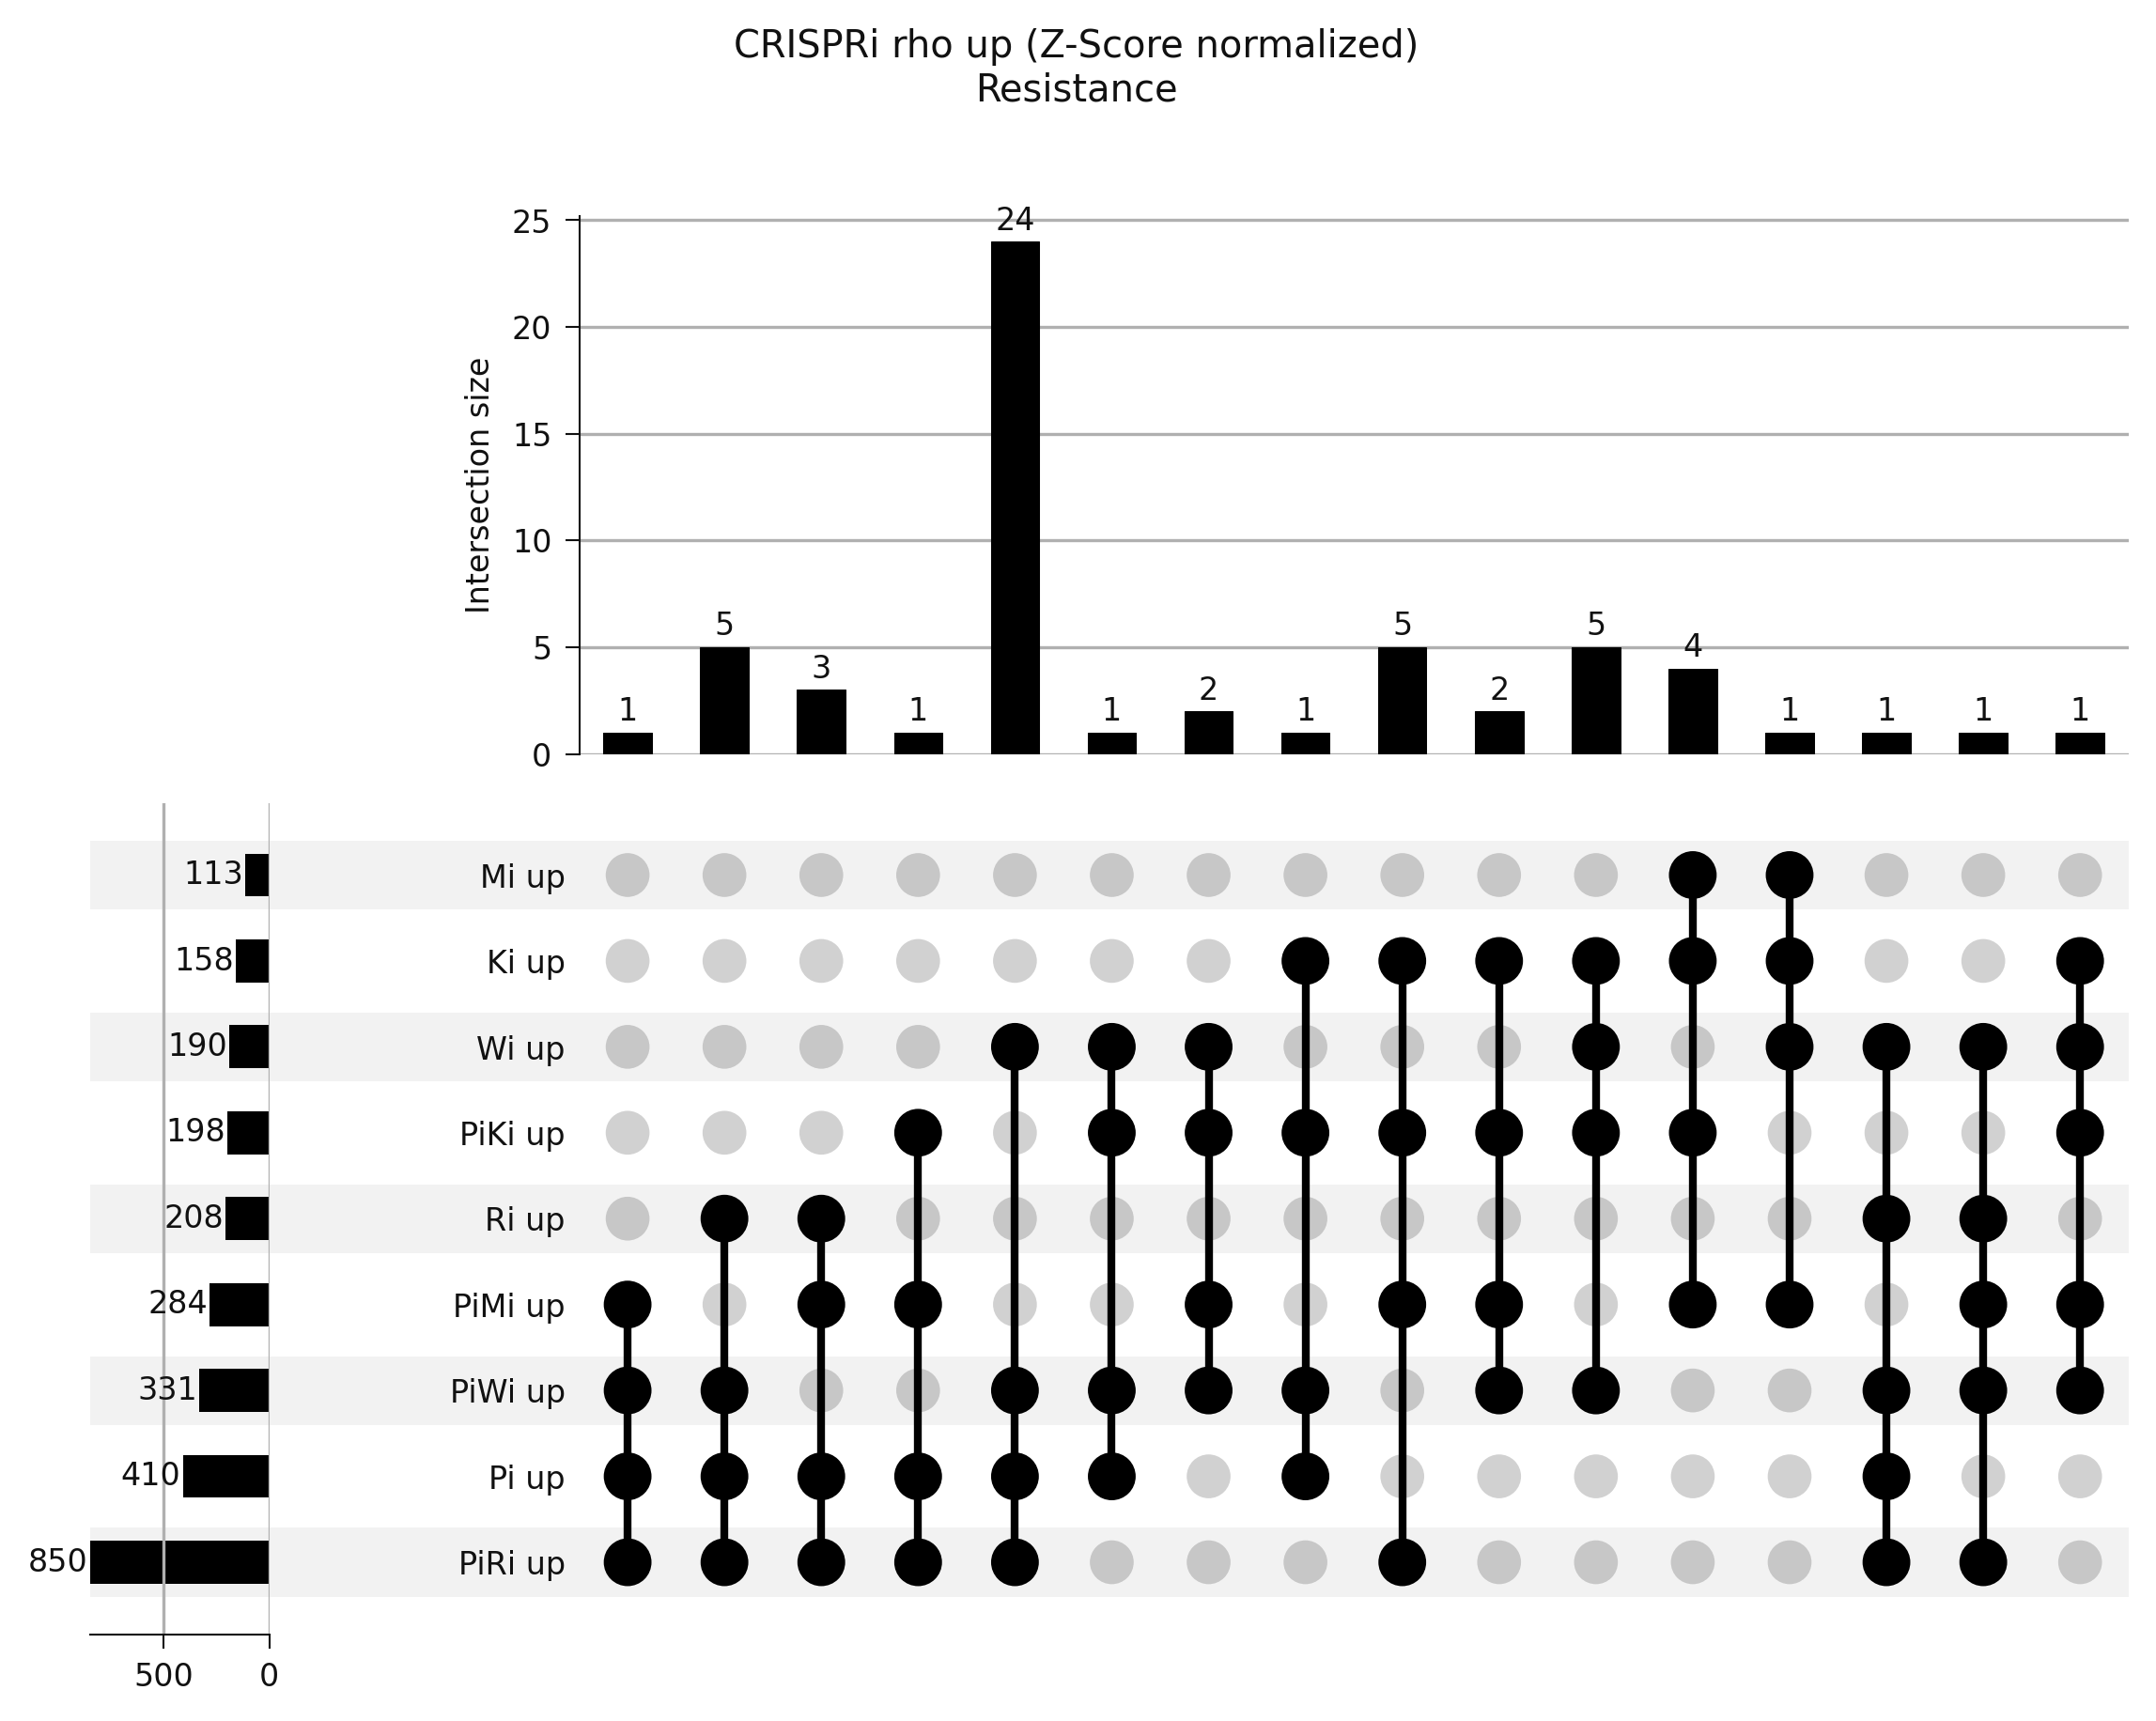

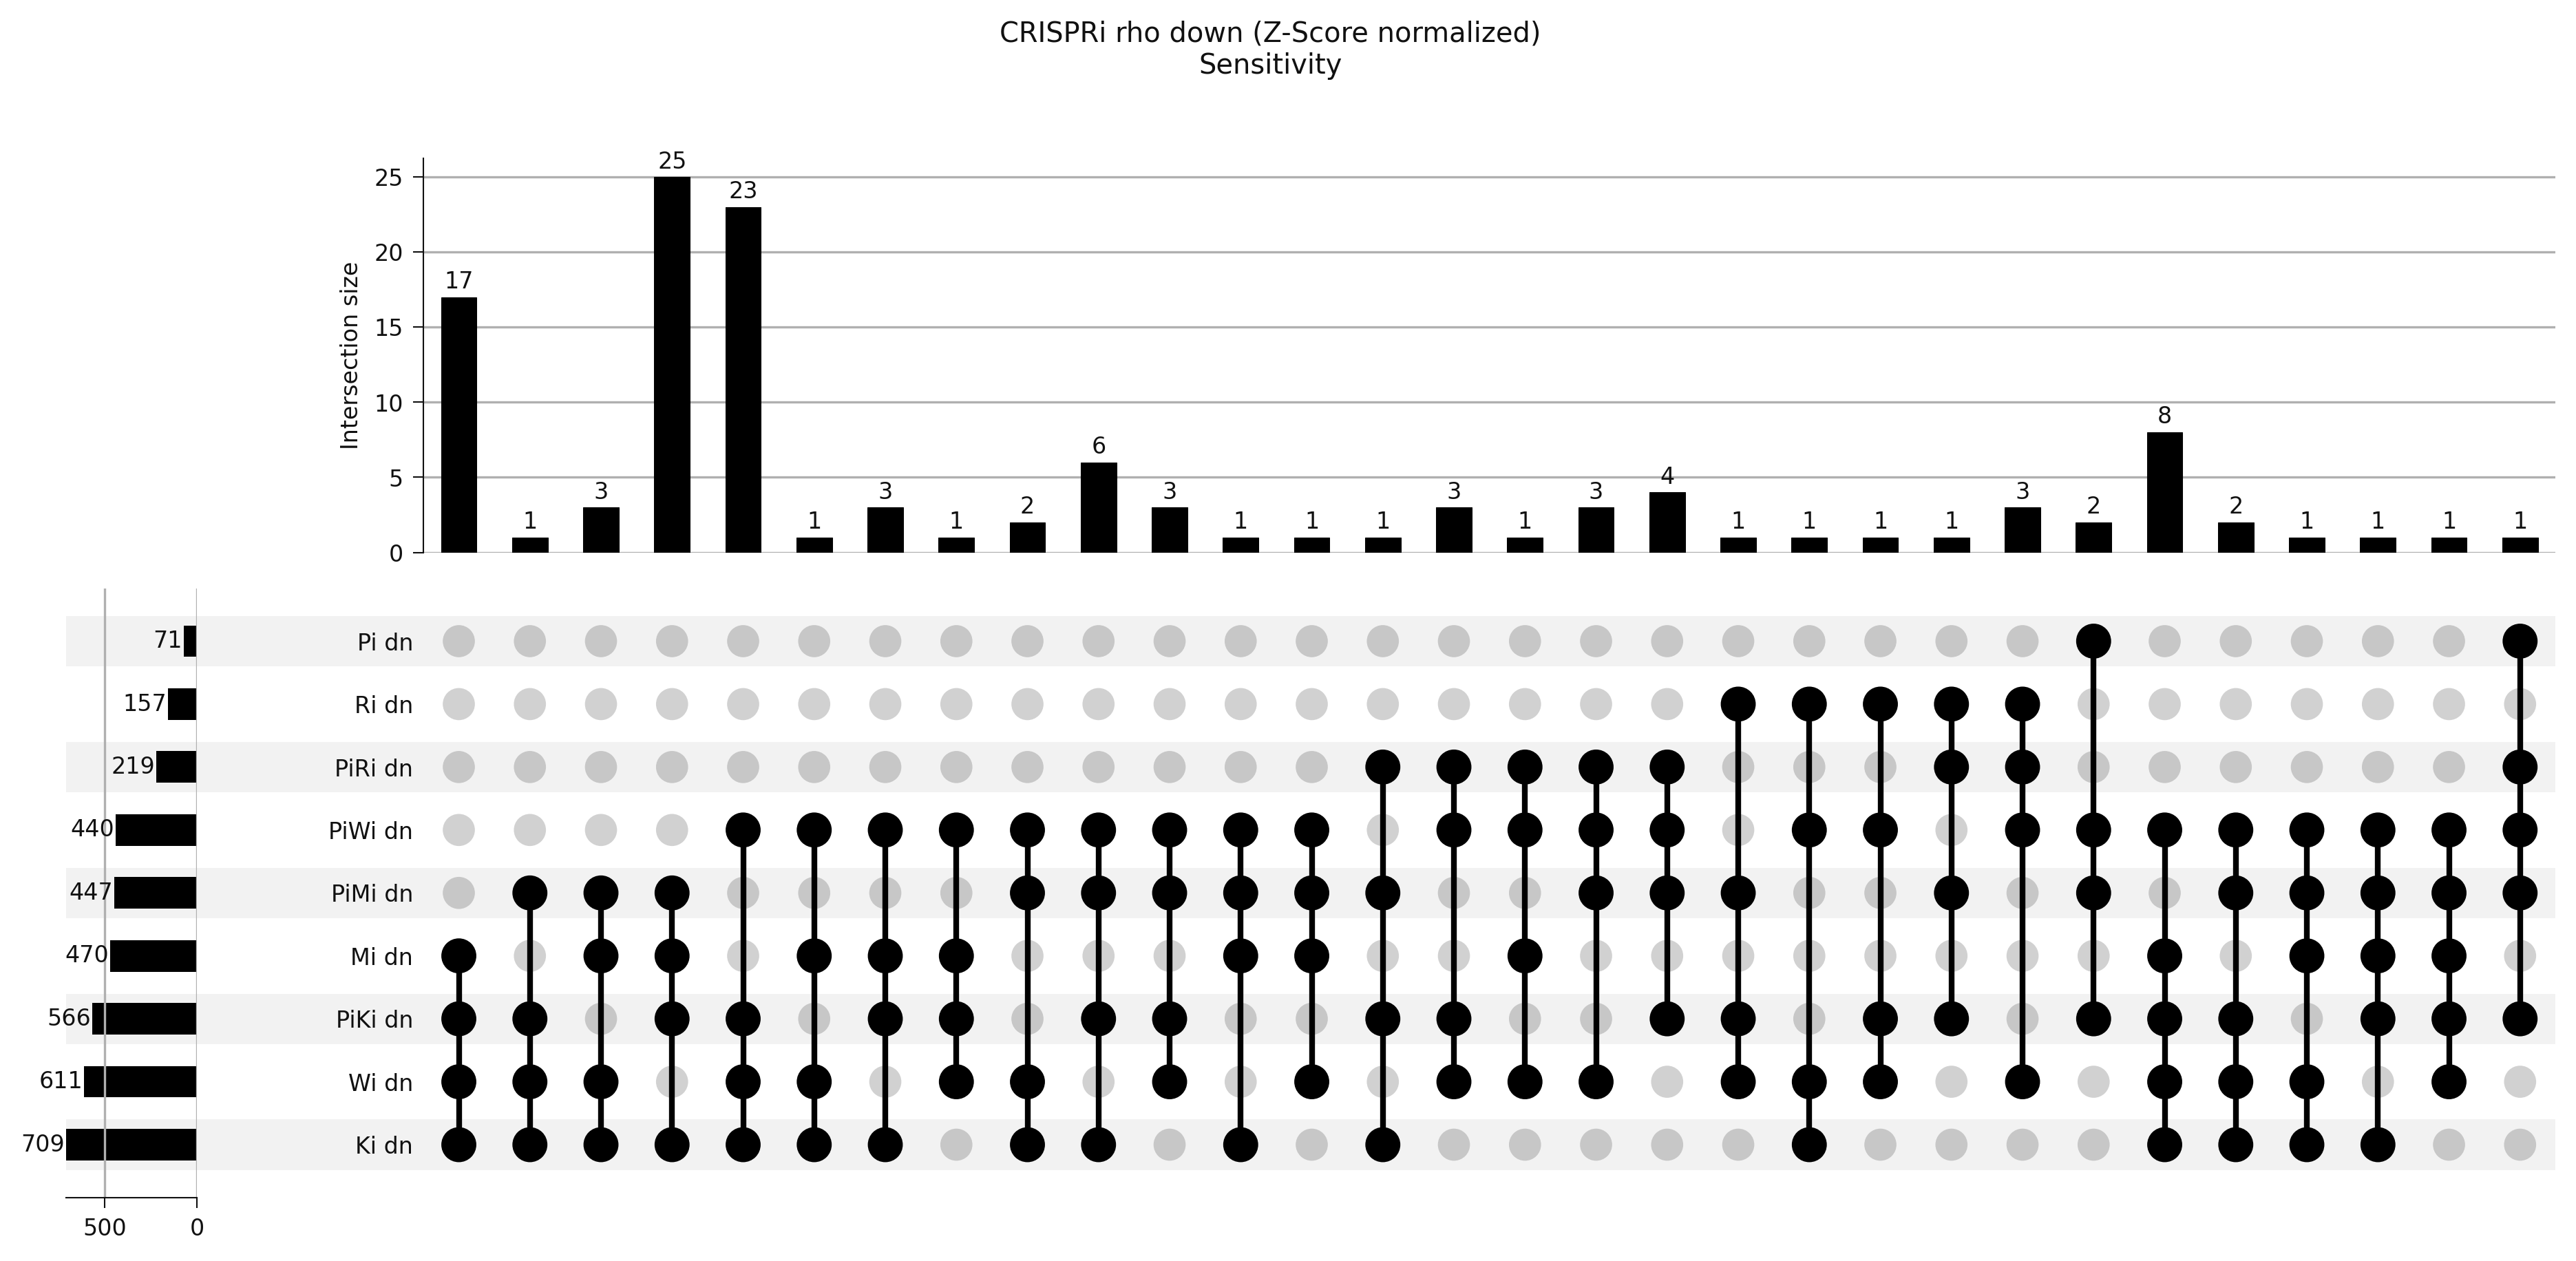

In [14]:
%%time 
# The PDF document
pdf_pages = PdfPages('figures/rho_zscore_upsetplot.pdf')

    
fig_u1 = plt.figure(figsize=(5, 5), dpi=300)
fig_u2 = plt.figure(figsize=(5, 5), dpi=300)

u1 = UpSet(
    UpSetData_up, subset_size='count',
#     orientation='vertical',
    show_counts='%d',
    min_degree=4
).plot(fig = fig_u1)
fig_u1.suptitle('CRISPRi rho up (Z-Score normalized)\nResistance')
pdf_pages.savefig(fig_u1)

u2 = UpSet(
    UpSetData_dn, subset_size='count',
#     orientation='vertical',
    show_counts='%d',
    min_degree=4
).plot(fig = fig_u2)
fig_u2.suptitle('CRISPRi rho down (Z-Score normalized)\nSensitivity')
pdf_pages.savefig(fig_u2)

# Write the PDF document to the disk
pdf_pages.close()

# Pathway analysis

In [15]:
from iPAGE2 import ipage2

In [16]:
!date

Sat Oct 30 07:03:11 UTC 2021
